In [2]:
!pip install wandb

!wandb login 9172fb113e07d174f618e9042047cc5c4adacc0f

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 698.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import wandb
import torch.autograd as autograd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Using device: cuda


In [ ]:
# Batch size during training
batch_size = 128

# Number of workers for dataloader
workers = 2

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

100%|██████████| 26421880/26421880 [00:13<00:00, 1994891.99it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169101.37it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 536298.79it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6354407.59it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



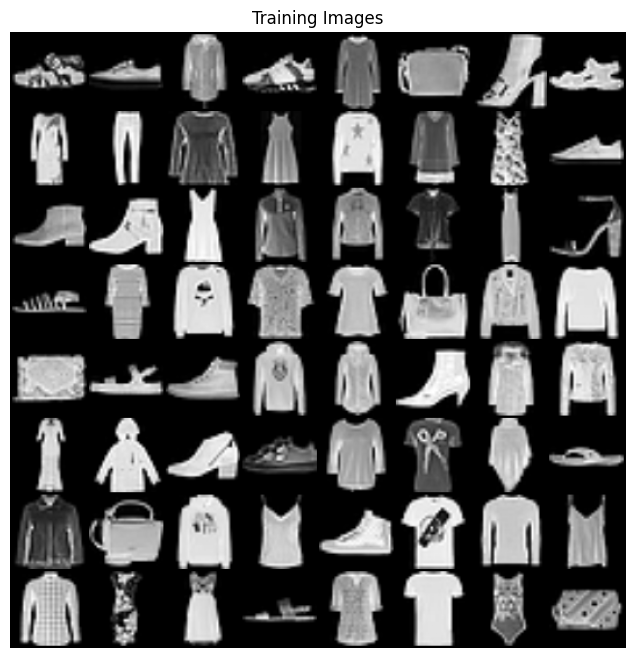

torch.Size([128, 1, 64, 64])
tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1, 2, 3, 2, 3, 3, 7, 9, 9, 3, 2, 4, 6, 3, 5,
        5, 3, 2, 0, 0, 8, 4, 2, 8, 5, 9, 2, 4, 9, 4, 4, 3, 4, 9, 7, 2, 0, 4, 5,
        4, 8, 2, 6, 7, 0, 2, 0, 6, 3, 3, 5, 6, 0, 0, 8, 7, 5, 1, 3, 5, 1, 0, 8,
        6, 6, 6, 7, 5, 3, 2, 1, 8, 1, 6, 3, 4, 3, 6, 3, 4, 6, 9, 9, 1, 2, 2, 0,
        3, 8, 7, 9, 4, 5, 6, 7, 8, 7, 6, 6, 9, 3, 9, 8, 9, 2, 4, 7, 5, 3, 2, 0,
        2, 4, 6, 9, 9, 1, 5, 9])
60000


In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.FashionMNIST(root='./data',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]), train=True, download=True)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
print(real_batch[0].shape)
print(real_batch[1])
print(len(dataloader.dataset))


In [6]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, name, latent_size, base_filter_size, final_channel_size, n_classes):
        super().__init__()
        self.name = name
        self.label_emb = nn.Embedding(n_classes, latent_size)  # Add label embedding for conditional GAN
        self.conv1 = nn.ConvTranspose2d(latent_size, base_filter_size * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(base_filter_size * 8)

        self.conv2 = nn.ConvTranspose2d(base_filter_size * 8, base_filter_size * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(base_filter_size * 4)

        self.conv3 = nn.ConvTranspose2d(base_filter_size * 4, base_filter_size * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(base_filter_size * 2)

        self.conv4 = nn.ConvTranspose2d(base_filter_size * 2, base_filter_size, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(base_filter_size)

        self.conv5 = nn.ConvTranspose2d(base_filter_size, final_channel_size, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, input, labels):
      label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
      input = input + label_embedding  # Add (not concatenate) noise and label embeddings
      # input = torch.cat([input, label_embedding], dim=1)

      # input is Z, going into a convolution
      x = self.conv1(input)
      x = self.bn1(x)
      x = F.relu(x)
      # state size. ``(ngf*8) x 4 x 4`` (ngf = base_filter_size)
      x = self.conv2(x)
      x = self.bn2(x)
      x = F.relu(x)
      # state size. ``(ngf*4) x 8 x 8``
      x = self.conv3(x)
      x = self.bn3(x)
      x = F.relu(x)
      # state size. ``(ngf*2) x 16 x 16``
      x = self.conv4(x)
      x = self.bn4(x)
      x = F.relu(x)
      # state size. ``(ngf) x 32 x 32``
      x = self.conv5(x)
      x = torch.tanh(x)
      # state size. ``(final_channel_size) x 64 x 64``

      return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, name, base_filter_size, initial_channel_size, n_classes):
    super().__init__()
    self.name = name
    self.label_emb = nn.Embedding(n_classes, 64*64)  # Add label embedding for conditional GAN
    self.conv1 = nn.Conv2d(initial_channel_size+1, base_filter_size, kernel_size=4, stride=2, padding=1, bias=False)
    self.conv2 = nn.Conv2d(base_filter_size, base_filter_size * 2, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(base_filter_size * 2)
    self.ln2 = nn.LayerNorm([base_filter_size * 2, 16, 16])
    self.conv3 = nn.Conv2d(base_filter_size * 2, base_filter_size * 4, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(base_filter_size * 4)
    self.ln3 = nn.LayerNorm([base_filter_size * 4, 8, 8])  # Adjusted size
    self.conv4 = nn.Conv2d(base_filter_size * 4, base_filter_size * 8, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn4 = nn.BatchNorm2d(base_filter_size * 8)
    self.ln4 = nn.LayerNorm([base_filter_size * 8, 4, 4])  # Adjusted size
    self.conv5 = nn.Conv2d(base_filter_size * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)

  def forward(self, input, labels):
    label_embedding = self.label_emb(labels).view(-1, 1, 64, 64)
    input = torch.cat([input, label_embedding], dim=1)  # Concatenate image and label embeddings on dim 1 since it is channel/depth dimension
    # input is ``(initial_channel_size+1) x 64 x 64``
    x = F.leaky_relu(self.conv1(input), 0.2, inplace=True)
    # state size. ``(ndf) x 32 x 32`` (ndf = base_filter_size)
    x = self.conv2(x)
    if self.name == "WGAN-GP":  # Layernorm only for WGAN-GP
      x = self.ln2(x)
    else:
      x = self.bn2(x)
    x = F.leaky_relu(x, 0.2, inplace=True)
    # state size. ``(ndf*2) x 16 x 16``
    x = self.conv3(x)
    if self.name == "WGAN-GP":  # Layernorm only for WGAN-GP
      x = self.ln3(x)
    else:
      x = self.bn3(x)
    x = F.leaky_relu(x, 0.2, inplace=True)
    # state size. ``(ndf*4) x 8 x 8``
    x = self.conv4(x)
    if self.name == "WGAN-GP":  # Layernorm only for WGAN-GP
      x = self.ln4(x)
    else:
      x = self.bn4(x)
    x = F.leaky_relu(x, 0.2, inplace=True)
    # state size. ``(ndf*8) x 4 x 4``
    x = self.conv5(x)
    # sigmoid activation only for DCGAN
    # No sigmoid activation for WGAN
    if self.name == "DCGAN":
      x = torch.sigmoid(x)
    # state size. ``1 x 1 x 1``

    return x

In [ ]:
def train_DCGAN(netG, netD, optimizerG, optimizerD, criterion, num_epochs, filter_size, lr):
  img_list = []
  G_losses = []
  D_losses = []
  iters = 0
  fixed_noise = torch.randn(64, nz, 1, 1, device=device)
  real_label = 1.0
  fake_label = 0.0

  if netG.name != netD.name:
    raise ValueError(f"Generator({netG.name}) and Discriminator({netD.name}) models must be same.")

  wandb.init(
    project="dl-ex3",
    name=f'{netG.name}_lr_{lr}_epochs_{num_epochs}_G_ReLU_D_LeakyReLU_depth_4_Batchnorm_{filter_size}',
    config={
    "learning_rate": lr,
    "epochs": num_epochs,
    }
  )

  for epoch in range(num_epochs):
      # For each batch in the dataloader
      for i, data in enumerate(dataloader, 0):
          real_images, labels = data[0].to(device), data[1].to(device)
          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################
          netD.zero_grad()

          # Train with real images
          real_output = netD(real_images, labels).view(-1)
          label_real = torch.full((real_images.size(0),), real_label, dtype=torch.float, device=device)
          errD_real = criterion(real_output, label_real)
          errD_real.backward()
          D_x = real_output.mean().item()

          ## Train with fake images
          # Generate batch of latent vectors
          noise = torch.randn(real_images.size(0), nz, 1, 1, device=device)
          # Generate fake image batch with G
          fake_images = netG(noise, labels)
          # Classify all fake batch with D
          fake_output = netD(fake_images.detach(), labels).view(-1)
          label_fake = torch.full((real_images.size(0),), fake_label, dtype=torch.float, device=device)
          # Calculate D's loss on the all-fake batch
          errD_fake = criterion(fake_output, label_fake)
          # Calculate the gradients for this batch, accumulated (summed) with previous gradients
          errD_fake.backward()
          D_G_z1 = fake_output.mean().item()
          # Compute error of D as sum over the fake and the real batches
          errD = errD_real + errD_fake
          # Update D
          optimizerD.step()

          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################
          netG.zero_grad()
          label_real.fill_(real_label)  # fake labels are real for generator cost
          # Since we just updated D, perform another forward pass of all-fake batch through D
          output = netD(fake_images, labels).view(-1)
          # Calculate G's loss based on this output
          errG = criterion(output, label_real)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimizerG.step()

          # Output training stats
          if i % 25 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch+1, num_epochs, i, len(dataloader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

          # Save Losses for plotting later
          G_losses.append(errG.item())
          D_losses.append(errD.item())

          # Check how the generator is doing by saving G's output on fixed_noise
          if (iters % 200 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
              with torch.no_grad():
                  fake = netG(fixed_noise, labels[:64]).detach().cpu()
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

          wandb.log({"Discriminator Loss": errD.item(), "Generator Loss": errG.item(), "D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2, "epoch": epoch, "iteration": iters})     # Wandb Plotting

          iters += 1
  wandb.finish()
  return netG, netD, G_losses, D_losses, img_list

In [ ]:
 # Loss functions for WGAN
def critic_loss(real_output, fake_output):
    return -(torch.mean(real_output) - torch.mean(fake_output))

def generator_loss(fake_output):
    return -torch.mean(fake_output)

# Gradient penalty for WGAN-GP
def gradient_penalty(critic, real_data, fake_data, labels):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    critic_output = critic(interpolated, labels)
    grad_outputs = torch.ones(critic_output.size(), device=device)

    gradients = autograd.grad(
        outputs=critic_output,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
# Training function modified for WGAN and WGAN-GP
def train_WGAN(netG, netC, optimizerG, optimizerD, num_epochs, filter_size, lr, use_gp=False, lambda_gp=10.0, critic_iterations=5):
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)  # Fixed noise for validation

    wandb.init(
      project="dl-ex3",
      name=f'{netG.name}_lr_{lr}_epochs_{num_epochs}_G_ReLU_D_LeakyReLU_depth_4_Batchnorm_{filter_size}',
      config={
      "learning_rate": lr,
      "epochs": num_epochs,
      }
    )

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            real_images, labels = data[0].to(device), data[1].to(device)

            # Update Critic multiple times for WGAN
            for _ in range(critic_iterations):
                netC.zero_grad()

                # Train with real images
                real_output = netC(real_images, labels).view(-1)

                # Generate fake images
                noise = torch.randn(real_images.size(0), nz, 1, 1, device=device)
                fake_images = netG(noise, labels)
                fake_output = netC(fake_images.detach(), labels).view(-1)

                # Compute critic loss
                loss_critic = critic_loss(real_output, fake_output)

                if use_gp:  # WGAN-GP: calculate gradient penalty and add to original WGAN loss
                    gp = gradient_penalty(netC, real_images, fake_images, labels)
                    loss_critic += lambda_gp * gp
                    # print("Gradient penalty", gp.item())

                loss_critic.backward(retain_graph=use_gp)  # we need to retain graph as we already computed gradient in GP, second backward pass
                optimizerD.step()

                if not use_gp:  # WGAN (without gradient penalty)
                    # Weight-clipping
                    for param in netC.parameters():
                        param.data.clamp_(-0.01, 0.01)

            # Update Generator
            netG.zero_grad()
            fake_output = netC(fake_images, labels).view(-1)
            loss_generator = generator_loss(fake_output)
            loss_generator.backward()
            optimizerG.step()

            # Output training stats
            if i % 25 == 0:
                print(f'[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_G: {loss_generator.item():.4f}\tLoss_C: {loss_critic.item():.4f}')

            G_losses.append(loss_generator.item())
            D_losses.append(loss_critic.item())

            # Checkpoint & Save generated images
            if iters % 200 == 0 or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise, labels[:64]).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            wandb.log({"Discriminator Loss": loss_critic.item(), "Generator Loss": loss_generator.item(), "epoch": epoch, "iteration": iters})     # Wandb Plotting

            iters += 1

        # Log WandB
        wandb.log({"Generator Loss": loss_generator.item(), "Critic Loss": loss_critic.item()})

        # Save model checkpoints
        # if epoch % 5 == 0:
        #     torch.save(netG.state_dict(), f"checkpoints/wgan_G_epoch_{epoch}.pth")
        #     torch.save(netC.state_dict(), f"checkpoints/wgan_C_epoch_{epoch}.pth")

    wandb.finish()

    return netG, netC, G_losses, D_losses, img_list


In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of GPUs available. Use 0 for CPU mode.
npgu = 1

def run(model_name, filter_size):

  # Size of feature maps in generator - relates to the depth of feature maps carried through the generator.
  ngf = filter_size

  # Size of feature maps in discriminator - sets the depth of feature maps propagated through the discriminator.
  ndf = filter_size

  netG = Generator(model_name, nz, ngf, nc, 10).to(device)
  netG.apply(weights_init)
  netD = Discriminator(model_name, ndf, nc, 10).to(device)
  netD.apply(weights_init)

  criterion = nn.BCELoss()
  DCGAN_lr = 0.0002
  WGAN_lr = 0.00005
  WGAN_GP_lr = 0.0001

  beta1 = 0.5  # Beta1 hyperparameter for Adam optimizers

  # Define optimizers based on the GAN type
  if model_name == "WGAN-GP":  # Adam optimizer is used for WGAN-GP, params from paper
      optimizerD = optim.Adam(netD.parameters(), lr=WGAN_GP_lr, betas=(beta1, 0.9))
      optimizerG = optim.Adam(netG.parameters(), lr=WGAN_GP_lr, betas=(beta1, 0.9))
  elif model_name == "WGAN":  # RMSprop optimizer is used for original WGAN, params from paper
      optimizerD = optim.RMSprop(netD.parameters(), lr=WGAN_lr)
      optimizerG = optim.RMSprop(netG.parameters(), lr=WGAN_lr)
  else:  # DCGAN
      optimizerD = optim.Adam(netD.parameters(), lr=DCGAN_lr, betas=(beta1, 0.999))
      optimizerG = optim.Adam(netG.parameters(), lr=DCGAN_lr, betas=(beta1, 0.999))

  num_epochs = 10

  if model_name == "DCGAN":
      G, D, G_losses, D_losses, img_list = train_DCGAN(netG, netD, optimizerG, optimizerD, criterion, num_epochs, filter_size, DCGAN_lr)
  elif model_name == "WGAN":
      G, D, G_losses, D_losses, img_list = train_WGAN(netG, netD, optimizerG, optimizerD, num_epochs, filter_size, WGAN_lr)
  elif model_name == "WGAN-GP":
      G, D, G_losses, D_losses, img_list = train_WGAN(netG, netD, optimizerG, optimizerD, num_epochs, filter_size, WGAN_GP_lr)

  return G, D, G_losses, D_losses, img_list

In [9]:
map = {
  0: "T-shirt/top",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}

def generate_images(generator, num_images, labels, nz, device):
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(noise, labels).detach().cpu()
    return vutils.make_grid(fake_images, padding=2, normalize=True)

# Function to find images with the target label
def find_images_with_label(dataloader, target_label, num_images=6):
    images = []
    labels = []
    count = 0
    for data, label in dataloader:  # Iterate through dataloader to get data and labels
        for i in range(len(label)):  # Iterate over the labels in the batch
            if label[i].item() == target_label:
                images.append(data[i])
                labels.append(label[i])
                count += 1
                if count == num_images:
                    break
        if count == num_images:
            break  # Exit outer loop once enough images are found
    return images, labels

**DO NOT RUN FROM HERE IF YOU ARE TESTING! LOOK FOR "UNTIL HERE" BELOW!**

In [ ]:
# Training
G_WGAN32, D_WGAN32, G_losses_WGAN32, D_losses_WGAN32, img_list_WGAN32 = run("WGAN", 32)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dchoiboi00 (cornell-tech-dl). Use `wandb login --relogin` to force relogin


[1/10][0/469]	Loss_G: 0.0017	Loss_C: -0.0052
[1/10][25/469]	Loss_G: 0.0293	Loss_C: -0.0508
[1/10][50/469]	Loss_G: 0.0904	Loss_C: -0.1861
[1/10][75/469]	Loss_G: 0.1828	Loss_C: -0.3405
[1/10][100/469]	Loss_G: 0.2449	Loss_C: -0.4314
[1/10][125/469]	Loss_G: 0.2507	Loss_C: -0.4811
[1/10][150/469]	Loss_G: 0.2905	Loss_C: -0.3973
[1/10][175/469]	Loss_G: 0.2526	Loss_C: -0.4977
[1/10][200/469]	Loss_G: 0.2960	Loss_C: -0.3770
[1/10][225/469]	Loss_G: 0.1973	Loss_C: -0.4544
[1/10][250/469]	Loss_G: 0.2814	Loss_C: -0.3694
[1/10][275/469]	Loss_G: 0.1147	Loss_C: -0.3294
[1/10][300/469]	Loss_G: 0.2741	Loss_C: -0.3480
[1/10][325/469]	Loss_G: 0.0974	Loss_C: -0.3181
[1/10][350/469]	Loss_G: 0.2634	Loss_C: -0.3059
[1/10][375/469]	Loss_G: 0.0878	Loss_C: -0.2814
[1/10][400/469]	Loss_G: 0.2529	Loss_C: -0.2718
[1/10][425/469]	Loss_G: 0.0682	Loss_C: -0.2303
[1/10][450/469]	Loss_G: 0.2654	Loss_C: -0.2856
[2/10][0/469]	Loss_G: 0.0945	Loss_C: -0.2929
[2/10][25/469]	Loss_G: 0.2416	Loss_C: -0.2467
[2/10][50/469]	Loss_G

Critic Loss,█▆▁▄▁▄▅▂▁▂
Discriminator Loss,█▁▂▄▃▄▄▃▄▄▃▃▃▃▂▂▃▂▁▃▂▁▂▂▂▂▂▂▃▂▂▂▂▃▂▂▂▃▂▃
Generator Loss,▄▇▇▂▇▇▂▁▃▂▂▇▆▃▇▇▄▇▆██▇█▆▅▄▇▂▆█▃█▁▂▇▃▃▃▇▇
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
iteration,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
Critic Loss,-0.38811
Discriminator Loss,-0.38811
Generator Loss,0.28418
epoch,9
iteration,4689


In [ ]:
# Training
torch.save(G_WGAN32.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/G_WGAN32.pth")
torch.save(D_WGAN32.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/D_WGAN32.pth")

In [ ]:
# Training
G_WGAN64, D_WGAN64, G_losses_WGAN64, D_losses_WGAN64, img_list_WGAN64 = run("WGAN", 64)

[1/10][0/469]	Loss_G: 0.0075	Loss_C: -0.0378
[1/10][25/469]	Loss_G: -0.0283	Loss_C: -0.1653
[1/10][50/469]	Loss_G: 0.2830	Loss_C: -0.2798
[1/10][75/469]	Loss_G: 0.0865	Loss_C: -0.3597
[1/10][100/469]	Loss_G: 0.4511	Loss_C: -0.5040
[1/10][125/469]	Loss_G: 0.2224	Loss_C: -0.5398
[1/10][150/469]	Loss_G: 0.4916	Loss_C: -0.5892
[1/10][175/469]	Loss_G: 0.2024	Loss_C: -0.5693
[1/10][200/469]	Loss_G: 0.4966	Loss_C: -0.5723
[1/10][225/469]	Loss_G: 0.2352	Loss_C: -0.5148
[1/10][250/469]	Loss_G: 0.5031	Loss_C: -0.5569
[1/10][275/469]	Loss_G: 0.2752	Loss_C: -0.5852
[1/10][300/469]	Loss_G: 0.5238	Loss_C: -0.6608
[1/10][325/469]	Loss_G: 0.2605	Loss_C: -0.7075
[1/10][350/469]	Loss_G: 0.5305	Loss_C: -0.7831
[1/10][375/469]	Loss_G: 0.2785	Loss_C: -0.7499
[1/10][400/469]	Loss_G: 0.5134	Loss_C: -0.6585
[1/10][425/469]	Loss_G: 0.3743	Loss_C: -0.7433
[1/10][450/469]	Loss_G: 0.3845	Loss_C: -0.8267
[2/10][0/469]	Loss_G: 0.5535	Loss_C: -0.8063
[2/10][25/469]	Loss_G: 0.3518	Loss_C: -0.7843
[2/10][50/469]	Loss_

Critic Loss,█▄▁▄▃▃▃▄▁▂
Discriminator Loss,█▅▃▃▃▄▁▂▂▂▂▂▂▁▂▃▂▂▂▂▁▂▁▂▃▂▁▁▂▂▁▁▂▃▂▂▂▃▁▂
Generator Loss,▁▃▄▄▅▃▇▇▆▇█▅▅▇▇▇▆▇▇██▄▇▇▇▅▅▆▆▅▆▇▆█▃▆▅▇▆▇
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▅▆▆▆▆▆▆▆▆▇▇▇███
iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
Critic Loss,-0.9575
Discriminator Loss,-0.9575
Generator Loss,0.4161
epoch,9
iteration,4689


In [ ]:
# Training
torch.save(G_WGAN64.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/G_WGAN64.pth")
torch.save(D_WGAN64.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/D_WGAN64.pth")

In [ ]:
# Training
G_WGAN_GP32, D_WGAN_GP32, G_losses_WGAN_GP32, D_losses_WGAN_GP32, img_list_WGAN_GP32 = run("WGAN-GP", 32)

[1/10][0/469]	Loss_G: 0.0047	Loss_C: -0.0106
[1/10][25/469]	Loss_G: 0.2887	Loss_C: -0.6210
[1/10][50/469]	Loss_G: 0.3164	Loss_C: -0.7303
[1/10][75/469]	Loss_G: 0.3220	Loss_C: -0.7497
[1/10][100/469]	Loss_G: 0.3246	Loss_C: -0.7527
[1/10][125/469]	Loss_G: 0.3042	Loss_C: -0.7237
[1/10][150/469]	Loss_G: 0.3326	Loss_C: -0.6164
[1/10][175/469]	Loss_G: 0.2625	Loss_C: -0.6986
[1/10][200/469]	Loss_G: 0.3200	Loss_C: -0.6801
[1/10][225/469]	Loss_G: 0.3158	Loss_C: -0.7031
[1/10][250/469]	Loss_G: 0.3171	Loss_C: -0.6779
[1/10][275/469]	Loss_G: 0.2172	Loss_C: -0.6562
[1/10][300/469]	Loss_G: 0.2936	Loss_C: -0.7086
[1/10][325/469]	Loss_G: 0.3123	Loss_C: -0.6763
[1/10][350/469]	Loss_G: 0.3145	Loss_C: -0.7069
[1/10][375/469]	Loss_G: 0.3209	Loss_C: -0.6820
[1/10][400/469]	Loss_G: 0.3084	Loss_C: -0.6601
[1/10][425/469]	Loss_G: 0.3288	Loss_C: -0.5824
[1/10][450/469]	Loss_G: 0.3296	Loss_C: -0.6918
[2/10][0/469]	Loss_G: 0.3290	Loss_C: -0.7032
[2/10][25/469]	Loss_G: 0.3150	Loss_C: -0.6844
[2/10][50/469]	Loss_G

Critic Loss,▂▁▁▂▄▅█▄▆▄
Discriminator Loss,▄▁▂▂▂▂▂▄▄▃▇▄▄▄▅▅▅▄▅▆▅▅▅▅▆▅▆▅▆▇▅▆▅▅▆▅▇▅▅█
Generator Loss,█▇█▇█▇███▆█▅▆▆▇▅▅█▆▅▅███▅▆▅▆▇▇██▆▄█▆▆▇▁▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
iteration,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▇▇▇▇▇▇▇▇▇█
Critic Loss,-0.45333
Discriminator Loss,-0.45333
Generator Loss,0.32512
epoch,9
iteration,4689


In [ ]:
# Training
torch.save(G_WGAN_GP32.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/G_WGAN_GP32.pth")
torch.save(D_WGAN_GP32.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/D_WGAN_GP32.pth")

In [ ]:
# Training
G_WGAN_GP64, D_WGAN_GP64, G_losses_WGAN_GP64, D_losses_WGAN_GP64, img_list_WGAN_GP64 = run("WGAN-GP", 64)

[1/10][0/469]	Loss_G: 0.0294	Loss_C: -0.0455
[1/10][25/469]	Loss_G: 0.6203	Loss_C: -1.3028
[1/10][50/469]	Loss_G: 0.6279	Loss_C: -1.4180
[1/10][75/469]	Loss_G: 0.2347	Loss_C: -1.1053
[1/10][100/469]	Loss_G: 0.7075	Loss_C: -1.4509
[1/10][125/469]	Loss_G: 0.2133	Loss_C: -0.7721
[1/10][150/469]	Loss_G: 0.7347	Loss_C: -1.3949
[1/10][175/469]	Loss_G: 0.7267	Loss_C: -1.4220
[1/10][200/469]	Loss_G: 0.7258	Loss_C: -1.4832
[1/10][225/469]	Loss_G: 0.7218	Loss_C: -1.5026
[1/10][250/469]	Loss_G: 0.7209	Loss_C: -1.5051
[1/10][275/469]	Loss_G: 0.7219	Loss_C: -1.4954
[1/10][300/469]	Loss_G: 0.7161	Loss_C: -1.4376
[1/10][325/469]	Loss_G: 0.7264	Loss_C: -1.4890
[1/10][350/469]	Loss_G: 0.7171	Loss_C: -1.4484
[1/10][375/469]	Loss_G: 0.7308	Loss_C: -1.4898
[1/10][400/469]	Loss_G: 0.7182	Loss_C: -0.9966
[1/10][425/469]	Loss_G: 0.7216	Loss_C: -1.4272
[1/10][450/469]	Loss_G: 0.6498	Loss_C: -0.7304
[2/10][0/469]	Loss_G: 0.6823	Loss_C: -1.4139
[2/10][25/469]	Loss_G: 0.5887	Loss_C: -1.3829
[2/10][50/469]	Loss_G

Critic Loss,▅▄▂█▁▃▇▇█▄
Discriminator Loss,▂▁▁▁▂▂▃▂▂▆▂▃▇▁▂▄▃▂▃▁▁▂▄▂▂▂▂▂▂▄▂▂▂▂▂█▅▂▂▄
Generator Loss,██▃▇██████▆██▆███▇▇████▁███▆▇██▇▇█▆███▇▄
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
iteration,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇████
Critic Loss,-1.40881
Discriminator Loss,-1.40881
Generator Loss,0.6927
epoch,9
iteration,4689


In [ ]:
# Training
torch.save(G_WGAN_GP64.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/G_WGAN_GP64.pth")
torch.save(D_WGAN_GP64.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/D_WGAN_GP64.pth")

In [ ]:
# Training
G32, D32, G_losses32, D_losses32, img_list32 = run("DCGAN", 32)

[1/10][0/469]	Loss_D: 1.3998	Loss_G: 1.9591	D(x): 0.5611	D(G(z)): 0.5292 / 0.1871
[1/10][25/469]	Loss_D: 0.7721	Loss_G: 2.8920	D(x): 0.5407	D(G(z)): 0.0017 / 0.1147
[1/10][50/469]	Loss_D: 0.1678	Loss_G: 3.1641	D(x): 0.9609	D(G(z)): 0.1057 / 0.0606
[1/10][75/469]	Loss_D: 0.2150	Loss_G: 2.9626	D(x): 0.8596	D(G(z)): 0.0485 / 0.0853
[1/10][100/469]	Loss_D: 0.3735	Loss_G: 3.0705	D(x): 0.9122	D(G(z)): 0.2114 / 0.0850
[1/10][125/469]	Loss_D: 0.6731	Loss_G: 2.8021	D(x): 0.7852	D(G(z)): 0.2855 / 0.0741
[1/10][150/469]	Loss_D: 1.7109	Loss_G: 3.9862	D(x): 0.9155	D(G(z)): 0.7745 / 0.0379
[1/10][175/469]	Loss_D: 0.7634	Loss_G: 1.7348	D(x): 0.6056	D(G(z)): 0.1535 / 0.1950
[1/10][200/469]	Loss_D: 0.8894	Loss_G: 1.2591	D(x): 0.5614	D(G(z)): 0.1915 / 0.3007
[1/10][225/469]	Loss_D: 1.1188	Loss_G: 2.6347	D(x): 0.7545	D(G(z)): 0.5243 / 0.0803
[1/10][250/469]	Loss_D: 0.6958	Loss_G: 2.2131	D(x): 0.6757	D(G(z)): 0.2041 / 0.1336
[1/10][275/469]	Loss_D: 1.3748	Loss_G: 3.1396	D(x): 0.7650	D(G(z)): 0.6378 / 0.05

D(G(z1)),▃▅▃▆▂▅▃▇▅▃▄▃▇█▂▄▅▃▆▄▄▃▃▃▄▃▅▂▃▂▁▂▄▃▂▂▂▂▁▂
D(G(z2)),█▂▁▁▄▆▃▆▅▅▂▇▃▅▃▂▂▄▃▆▄▆▂█▅▂▄▅▃▂▁▃▂▁▄▅▃▃▂▄
D(x),▄▁▅▃▄▆▄▄▄▃▆▃▅▆▅▅▇▅▅▇▅▆▆▄▄▆▇▅▆▇▆▅▅▆▃█▅▇▇▆
Discriminator Loss,▁▅▆▆█▅▇▅▅▅▃▆▄▄▄▇▃▃▃▆▃▄▃▃▂▄▃▅▅▄█▂▂▂▂▇▄▄▂▄
Generator Loss,▅▂▁▂▃▂▂▂▄▃▂▃▂▃▄▃▅▄▄▃▄▂▆▆▃▃▂▅▅▃▅▄▃▃▄█▄▅▄▆
epoch,▁▁▁▁▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
iteration,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
D(G(z1)),0.05021
D(G(z2)),0.10493
D(x),0.80632
Discriminator Loss,0.3306


In [ ]:
# Training
torch.save(G32.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/G32.pth")
torch.save(D32.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/D32.pth")

In [ ]:
# Training
G64, D64, G_losses64, D_losses64, img_list64 = run("DCGAN", 64)

[1/10][0/469]	Loss_D: 1.4093	Loss_G: 4.2601	D(x): 0.5665	D(G(z)): 0.4875 / 0.2355
[1/10][25/469]	Loss_D: 0.8576	Loss_G: 2.3175	D(x): 0.6765	D(G(z)): 0.1490 / 0.1912
[1/10][50/469]	Loss_D: 1.1099	Loss_G: 2.8995	D(x): 0.7850	D(G(z)): 0.4352 / 0.1032
[1/10][75/469]	Loss_D: 1.2932	Loss_G: 3.4113	D(x): 0.8696	D(G(z)): 0.5708 / 0.0509
[1/10][100/469]	Loss_D: 1.5322	Loss_G: 3.9550	D(x): 0.8711	D(G(z)): 0.7045 / 0.0376
[1/10][125/469]	Loss_D: 2.3006	Loss_G: 0.9804	D(x): 0.2178	D(G(z)): 0.0987 / 0.4499
[1/10][150/469]	Loss_D: 0.8516	Loss_G: 2.8158	D(x): 0.6816	D(G(z)): 0.2739 / 0.1016
[1/10][175/469]	Loss_D: 1.4883	Loss_G: 3.9712	D(x): 0.7936	D(G(z)): 0.6042 / 0.0454
[1/10][200/469]	Loss_D: 1.0431	Loss_G: 2.9795	D(x): 0.6715	D(G(z)): 0.3501 / 0.0707
[1/10][225/469]	Loss_D: 1.1144	Loss_G: 1.6103	D(x): 0.5149	D(G(z)): 0.1991 / 0.2424
[1/10][250/469]	Loss_D: 1.2800	Loss_G: 1.2667	D(x): 0.4854	D(G(z)): 0.1864 / 0.3553
[1/10][275/469]	Loss_D: 0.8317	Loss_G: 2.7110	D(x): 0.7543	D(G(z)): 0.3403 / 0.09

D(G(z1)),█▆▂▃▇▅▃▆▄▃▄▃▃▂▄▃▄▃▂▅▄▂▂▆▂▂▁▂▃▂▁▃▂▂▂▂▁▃▂▁
D(G(z2)),▅▄▇▄█▂▄▄▂▁▄▇▆▃▂█▆▃▃▂▂▂▂▂▄▂▂▂▃▃▃▅▁▂▁▃▁▁▃▁
D(x),▃▃▄▄▄▅▄▄▆▃▂▇▆▄▆▄▆▁▄▆▅▇▆▆▅▄▇▆█▅▇█▇▆▆▅██▆█
Discriminator Loss,▇▅▆▆█▄▆▄▄▅▅▅▃▃▅▃▄▅▄▄▃▃▅▃▇▃▂▃▃▄▅▂▂▂▂▂▂▃▅▁
Generator Loss,▁▁▃▁▃▃▂▃▂▂▃▃▄▃▂▂▁▃▂▄▅▂▂▃▃▅▃▃▅▄▄▇█▁▄▅▄▄▄▃
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
iteration,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
D(G(z1)),0.08287
D(G(z2)),0.01349
D(x),0.96094
Discriminator Loss,0.13555


In [ ]:
# Training
torch.save(G64.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/G64.pth")
torch.save(D64.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/model/D64.pth")

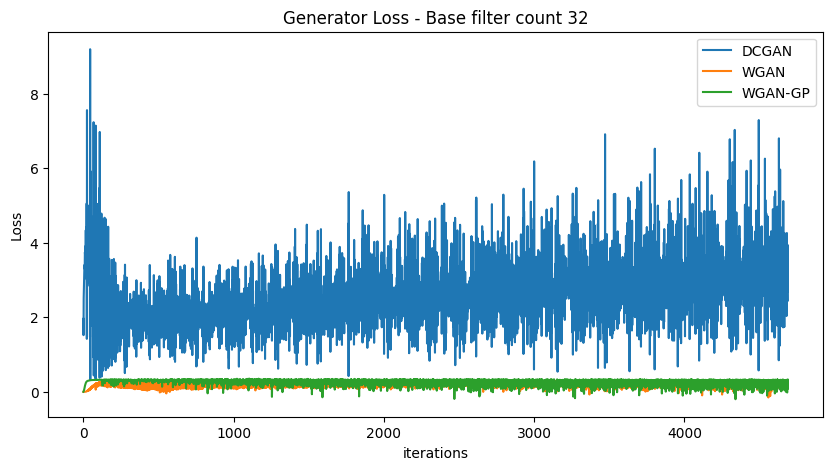

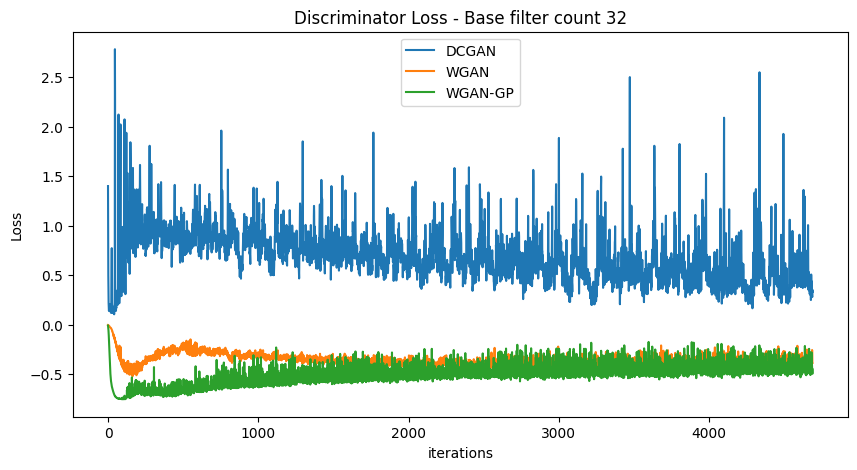

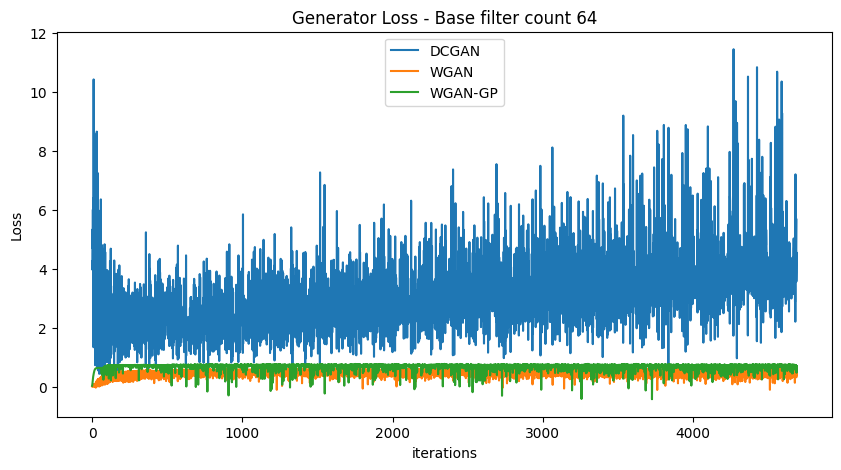

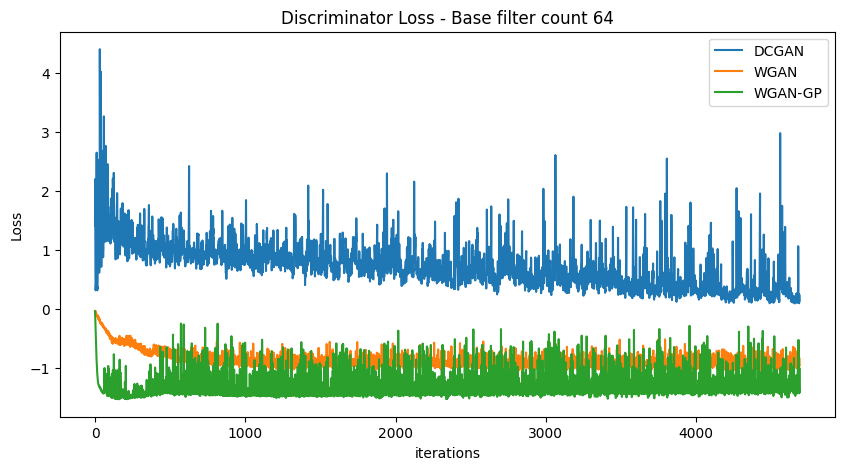

In [ ]:
# Four loss graphs:
# 1. Architecture A (base filter count 32): G_loss - plot DCGAN, WGAN, WGAN-GP
# 2. Architecture A (base filter count 32): D_loss - plot DCGAN, WGAN, WGAN-GP
# 3. Architecture B (base filter count 64): G_loss - plot DCGAN, WGAN, WGAN-GP
# 4. Architecture B (base filter count 64): D_loss - plot DCGAN, WGAN, WGAN-GP

plt.figure(figsize=(10,5))
plt.title("Generator Loss - Base filter count 32")
plt.plot(G_losses32,label="DCGAN")
plt.plot(G_losses_WGAN32,label="WGAN")
plt.plot(G_losses_WGAN_GP32,label="WGAN-GP")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Discriminator Loss - Base filter count 32")
plt.plot(D_losses32,label="DCGAN")
plt.plot(D_losses_WGAN32,label="WGAN")
plt.plot(D_losses_WGAN_GP32,label="WGAN-GP")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator Loss - Base filter count 64")
plt.plot(G_losses64,label="DCGAN")
plt.plot(G_losses_WGAN64,label="WGAN")
plt.plot(G_losses_WGAN_GP64,label="WGAN-GP")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Discriminator Loss - Base filter count 64")
plt.plot(D_losses64,label="DCGAN")
plt.plot(D_losses_WGAN64,label="WGAN")
plt.plot(D_losses_WGAN_GP64,label="WGAN-GP")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

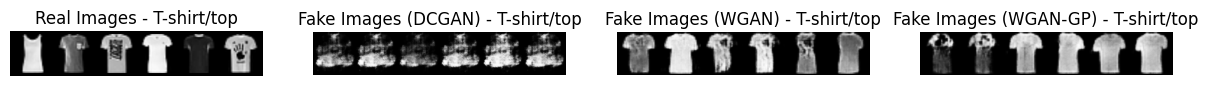

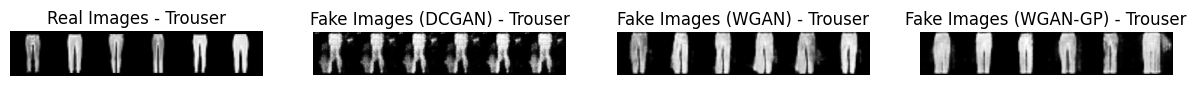

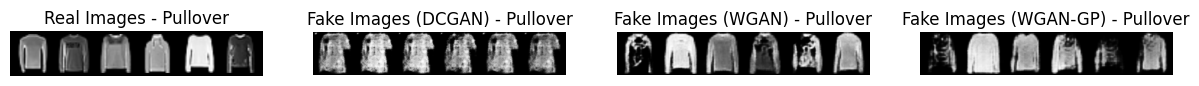

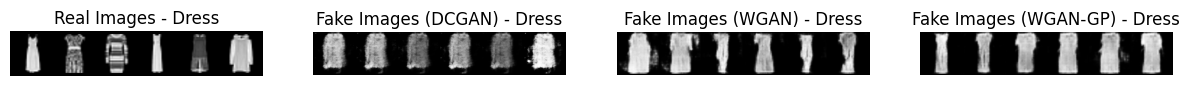

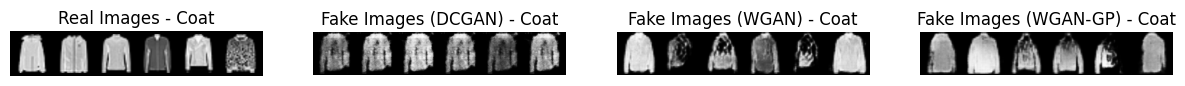

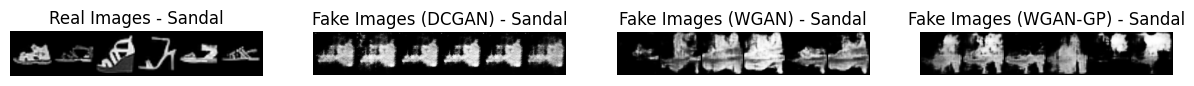

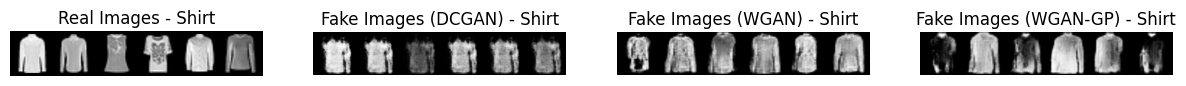

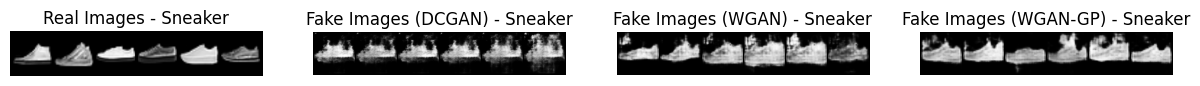

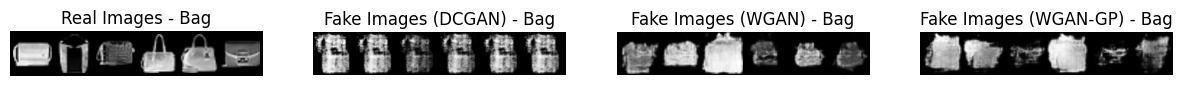

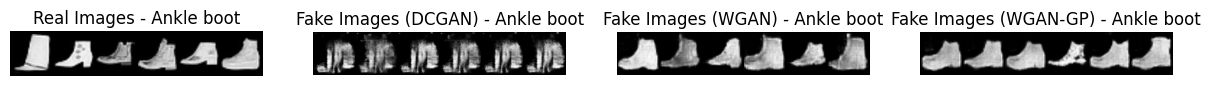

In [ ]:
for i, name in map.items():
  plt.figure(figsize=(15,15))

  label = torch.full((6,), i, dtype=torch.long, device=device)
  real_images, _ = find_images_with_label(dataloader, i, 6)
  fake_images_DCGAN = generate_images(G64, 6, label, nz, device)
  fake_images_WGAN = generate_images(G_WGAN64, 6, label, nz, device)
  fake_images_WGAN_GP = generate_images(G_WGAN_GP64, 6, label, nz, device)

  # real images
  plt.subplot(1,4,1)
  plt.axis("off")
  plt.title(f"Real Images - {name}")
  plt.imshow(np.transpose(vutils.make_grid(real_images, padding=5, normalize=True).cpu(),(1,2,0)))
  # fake images, DCGAN
  plt.subplot(1,4,2)
  plt.axis("off")
  plt.title(f"Fake Images (DCGAN) - {name}")
  plt.imshow(np.transpose(fake_images_DCGAN,(1,2,0)))
  # fake images, WGAN
  plt.subplot(1,4,3)
  plt.axis("off")
  plt.title(f"Fake Images (WGAN) - {name}")
  plt.imshow(np.transpose(fake_images_WGAN,(1,2,0)))
  # fake images, WGAN-GP
  plt.subplot(1,4,4)
  plt.axis("off")
  plt.title(f"Fake Images (WGAN-GP) - {name}")
  plt.imshow(np.transpose(fake_images_WGAN_GP,(1,2,0)))

  plt.show()



**UNTIL HERE!!!**


**YOU CAN RUN FROM HERE TO GENERATE IMAGES USING TRAINED MODEL**

<ipython-input-16-fd202344b0a2>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(path))


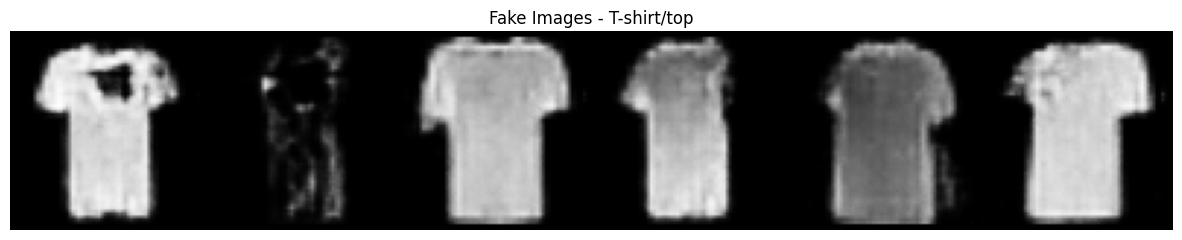

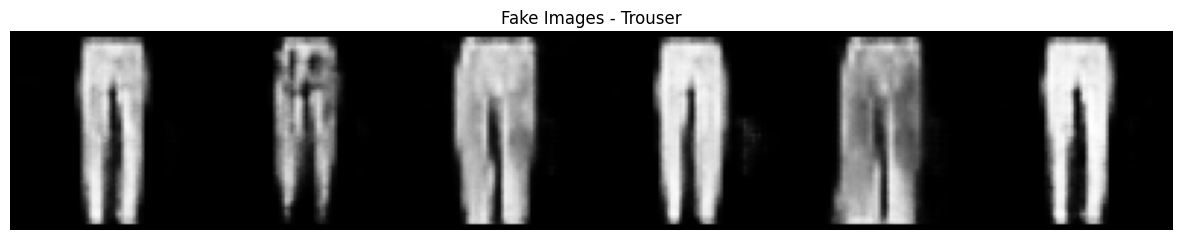

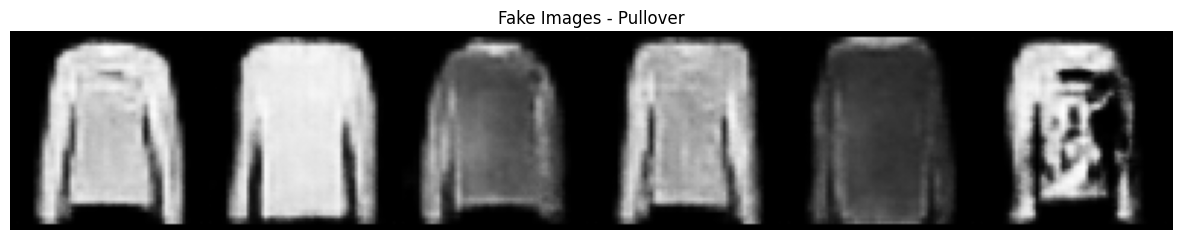

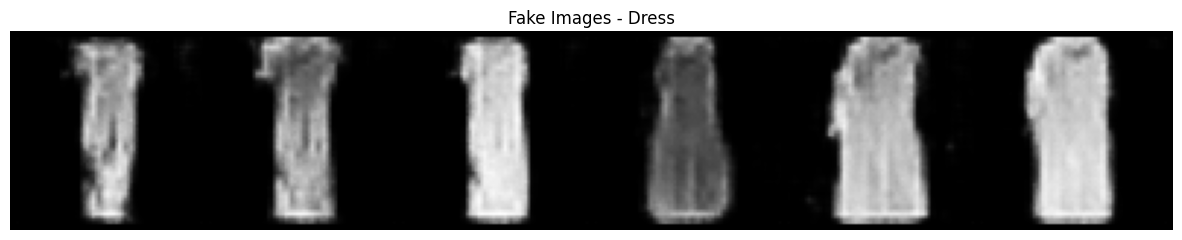

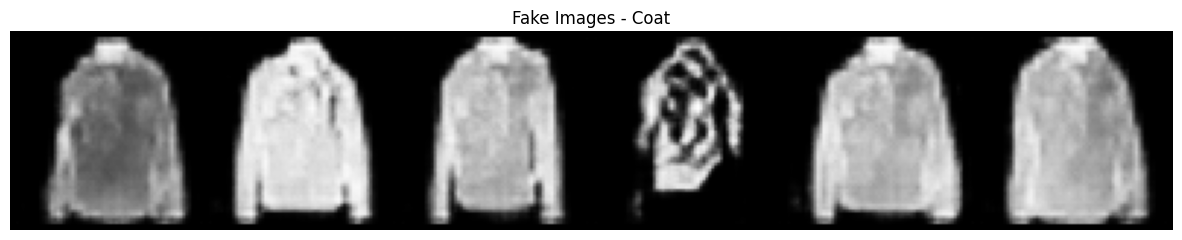

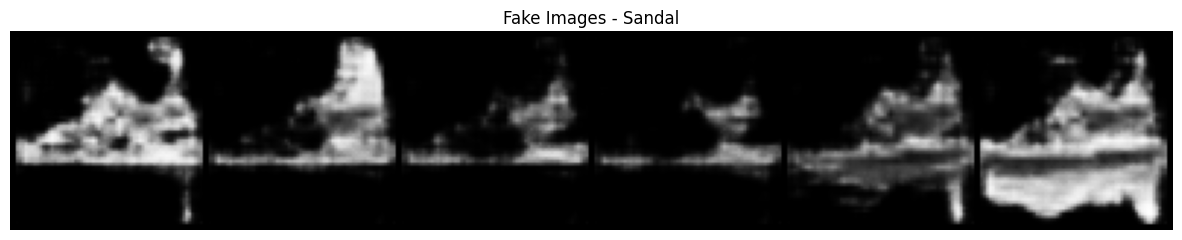

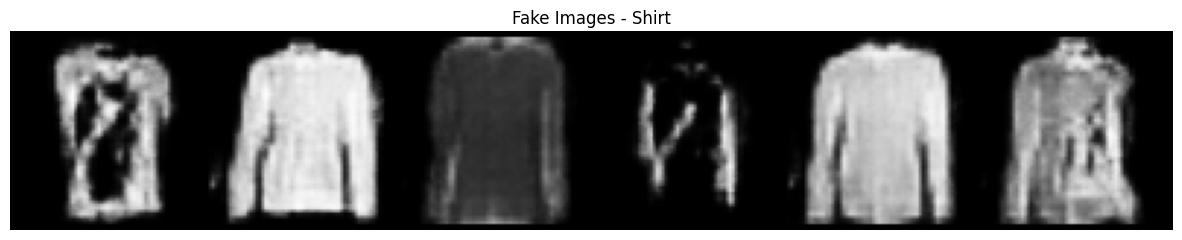

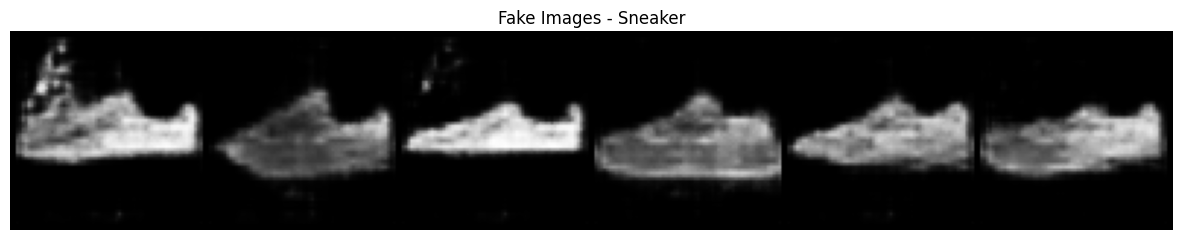

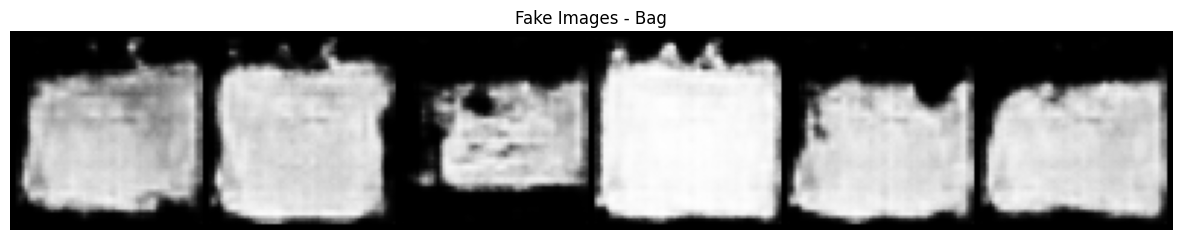

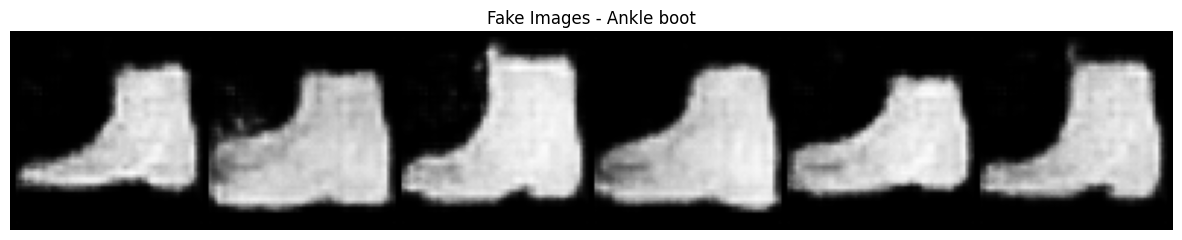

In [16]:
def generate_images_from_trained_model(path, name, latent_size, filter_size, nc=1):
  netG = Generator(name, latent_size, filter_size, nc, 10).to(device)
  netG.apply(weights_init)
  netG.load_state_dict(torch.load(path))
  netG.eval()

  for i, name in map.items():
    label = torch.full((6,), i, dtype=torch.long, device=device)
    fake_images_DCGAN32 = generate_images(netG, 6, label, latent_size, device)
    plt.figure(figsize=(15,15))
    # fake images, DCGAN
    plt.axis("off")
    plt.title(f"Fake Images - {name}")
    plt.imshow(np.transpose(fake_images_DCGAN32,(1,2,0)))

generate_images_from_trained_model("/content/drive/MyDrive/ex3_dk865_yc2822/model/G_WGAN_GP64.pth", "WGAN-GP", 100, 64)